# Outline
This tutorial demonstrates various data cleaning stages on a sample astronomical dataset.

1) Setting up the environment
2) Downloading and importing the dataset
3) Inspect and visualize the dataset content
4) Run some consistency checks on the dataset
5) Detect and handle missing data values
6) Detect outliers

The original dataset is the `Stellar Classification Dataset`, available here:

- SDSS DR17: https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17. 
- SDSS DR19: https://www.kaggle.com/datasets/randelmaglaya/sdss-dr19-2025/data

For this tutorial, however, we will use a modified "dirtier" version of the dataset, in which we artificially added corrupted, missing data, and outliers/anomalies.

# Configuring the environment

## Module installation
We’ll begin by installing the necessary Python modules for this tutorial.

In [53]:
import os

# - Install modules from requirements.txt if present
if os.path.isfile("requirements.txt"):
  print("Installing modules from local requirements.txt file ...")
  %pip install -q -r requirements.txt
else:
  print("Installing modules ...")

  %pip install -q gdown                                
  %pip install -q matplotlib seaborn                          
  %pip install -q pandas scikit-learn umap-learn[plot]
  
  # - Create requirements file
  %pip freeze > requirements.txt

Installing modules ...
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


## Import modules
Next, we import the essential modules needed throughout the tutorial.

In [54]:
###########################
##   STANDARD MODULES
###########################
import os
from pathlib import Path
import shutil
import gdown
import random
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns

###########################
##   ML MODULES
###########################
import pandas as pd
from pandas import read_csv
from sklearn.feature_selection import VarianceThreshold
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import IsolationForest
import umap, umap.plot

## Set random seeds
Let's define a function to set random numpy/torch seeds to make random generation reproducible.

In [5]:
def set_seed(seed=42):
  """ Set random seed """
  random.seed(seed)
  np.random.seed(seed)

# - Set the seed
set_seed(1)

## Project folders
We create a working directory `rundir` to run the tutorial in.

In [6]:
topdir= os.getcwd()
rundir= os.path.join(topdir, "run-data_cleaning")
path = Path(rundir)
path.mkdir(parents=True, exist_ok=True)

# Dataset
For this tutorial, we will use the [**Stellar Classification Dataset - SDSS17**](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17).

This dataset contains **100,000** observations of sources taken by the SDSS (Sloan Digital Sky Survey) in various optical bands. Every observation is described by **17 feature columns** and **1 class column** which identifies it to be either a **star**, **galaxy** or **quasar**.

1) `obj_ID`: Object Identifier, the unique value that identifies the object in the image catalog used by the CAS
2) `alpha`: Right Ascension angle (at J2000 epoch)
3) `delta`: Declination angle (at J2000 epoch)
4) `u`: Ultraviolet filter in the photometric system
5) `g`: Green filter in the photometric system
6) `r`: Red filter in the photometric system
7) `i`: Near Infrared filter in the photometric system
8) `z`: Infrared filter in the photometric system
9) `run_ID`: Run Number used to identify the specific scan
10) `rereun_ID`: Rerun Number to specify how the image was processed
11) `cam_col`: Camera column to identify the scanline within the run
12) `field_ID`: Field number to identify each field
13) `spec_obj_ID`: Unique ID used for optical spectroscopic objects (this means that 2 different observations with the same spec_obj_ID must share the output class)
14) `class`: object class (galaxy, star or quasar object)
15) `redshift`: redshift value based on the increase in wavelength
16) `plate`: plate ID, identifies each plate in SDSS
17) `MJD`: Modified Julian Date, used to indicate when a given piece of SDSS data was taken
18) `fiber_ID`: fiber ID that identifies the fiber that pointed the light at the focal plane in each observation

## Dataset Download
Next, we download the dataset from Google Drive and unzip it in the main folder.

In [123]:
# - Download dataset
def download_data(fname, url, destdir, force=False):
  """ Download dataset """
  
  # - Download dataset (if not previously downloaded)
  fname_full= os.path.join(destdir, fname)
  if force or not os.path.isfile(fname_full):
    print(f"Downloading data from url {url} ...")
    gdown.download(url, fname, quiet=False)
    print("DONE!")
    
  # - Moving data to destdir
  if os.path.isfile(fname) and os.path.isdir(destdir):
    print(f"Moving data {fname} to dir %s ..." % (destdir))
    shutil.move(fname, fname_full)  

# - Set dataset URL & paths
dataset_name= 'star_classification.csv'
dataset_name_fullpath= os.path.join(rundir, dataset_name)
#dataset_url= 'https://drive.google.com/uc?export=download&id=170VmM5ETBRgY93vD0phuas_6PIgq08u-' # DR17
#dataset_url= 'https://drive.google.com/uc?export=download&id=1RH1v7q2bukXV4BNQhp30EsOdncxgIrwk' # DR19
dataset_url= 'https://drive.google.com/uc?export=download&id=1rFoh30_zNdDJJ_tdnEdVpepbATOpvx5D' # DR19 dirty

# - Download dataset
download_data(dataset_name, dataset_url, rundir, force=True)

Downloading...
From: https://drive.google.com/uc?export=download&id=1rFoh30_zNdDJJ_tdnEdVpepbATOpvx5D
To: /home/riggi/Analysis/MLProjects/INAF-USC-C-AI/school2026/notebooks/star_classification.csv
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15.7M/15.7M [00:00<00:00, 49.0MB/s]


DONE!
Moving data star_classification.csv to dir /home/riggi/Analysis/MLProjects/INAF-USC-C-AI/school2026/notebooks/run-data_cleaning ...


## Dataset load
Let's load the downloaded dataset as a Pandas data frame.

In [124]:
print(f"Loading data from file {dataset_name_fullpath} ...")
try:
  df= pd.read_csv(dataset_name_fullpath, sep=',')
  print(df)
  #print(df.head())
  #print(df.tail())
except UnicodeDecodeError:
  print(f"Unicode decoding error when loading data file {dataset_name_fullpath}!")

Loading data from file /home/riggi/Analysis/MLProjects/INAF-USC-C-AI/school2026/notebooks/run-data_cleaning/star_classification.csv ...
                     obj_ID       alpha      delta         u         g  \
0       1237652947459637379   17.941809  -9.816818      -inf  17.43624   
1       1237671123217940946  122.127448   7.336519  18.55875  16.56873   
2       1237672026783416538  336.686095  39.020594  15.23208  15.55459   
3       1237663542064119850  311.369182  -1.009367  18.65634  17.48205   
4       1237648702973542435  199.516504  -1.123175  18.00832  16.83256   
...                     ...         ...        ...       ...       ...   
101995  1237655126082846840  184.088675   5.459447  19.31630  17.96200   
101996  1237664853114159283  232.163943  27.435908  19.40644  18.14540   
101997  1237658492286599185  196.790855   9.552958  18.82735  18.42521   
101998  1237657595152171182  127.857481  40.956219       NaN  14.48068   
101999  1237679502705492124  353.260324  18.903515

Let's inspect the loaded data frame.

In [125]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102000 entries, 0 to 101999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       102000 non-null  int64  
 1   alpha        102000 non-null  float64
 2   delta        102000 non-null  float64
 3   u            100067 non-null  float64
 4   g            100473 non-null  float64
 5   r            101179 non-null  float64
 6   i            101183 non-null  float64
 7   z            100478 non-null  float64
 8   run_ID       102000 non-null  int64  
 9   rerun_ID     102000 non-null  int64  
 10  cam_col      102000 non-null  int64  
 11  field_ID     102000 non-null  int64  
 12  spec_obj_ID  102000 non-null  uint64 
 13  class        102000 non-null  object 
 14  redshift     102000 non-null  float64
 15  plate        102000 non-null  int64  
 16  MJD          102000 non-null  int64  
 17  fiber_ID     102000 non-null  int64  
dtypes: float64(8), int64(8),

In [126]:
df.describe()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,redshift,plate,MJD,fiber_ID
count,1.020000e+05,102000.000000,102000.000000,1.000670e+05,1.004730e+05,1.011790e+05,1.011830e+05,1.004780e+05,102000.000000,102000.0,102000.000000,102000.000000,1.020000e+05,102000.000000,102000.000000,102000.000000,102000.000000
mean,1.237663e+18,177.063802,24.989593,NaN,NaN,inf,inf,NaN,3981.321804,301.0,3.286676,186.076657,2.917863e+18,0.170501,2591.499275,53914.475990,342.084794
std,7.277021e+12,78.292749,20.562426,NaN,NaN,NaN,NaN,NaN,1694.314007,0.0,1.626186,140.984758,2.503074e+18,0.437256,2223.162147,1551.860652,216.731915
min,1.237646e+18,0.011306,-19.306395,-inf,-inf,9.823509e+00,9.337089e+00,-inf,109.000000,301.0,1.000000,11.000000,2.994897e+17,-0.004136,266.000000,51608.000000,1.000000
25%,1.237658e+18,136.008447,6.657628,1.821624e+01,1.685172e+01,1.619863e+01,1.586763e+01,1.562012e+01,2826.000000,301.0,2.000000,85.000000,1.333178e+18,0.000003,1184.000000,52733.000000,160.000000
50%,1.237662e+18,179.945866,23.851388,1.887664e+01,1.751741e+01,1.689665e+01,1.660286e+01,1.642687e+01,3903.000000,301.0,3.000000,151.000000,2.341980e+18,0.046372,2080.000000,53726.000000,329.000000
75%,1.237667e+18,224.281339,40.285868,1.927474e+01,1.805712e+01,1.759093e+01,1.734983e+01,1.723462e+01,5061.000000,301.0,5.000000,247.000000,3.275280e+18,0.095634,2909.000000,54585.000000,502.000000
max,1.237681e+18,359.999615,84.490494,inf,inf,inf,inf,inf,8162.000000,301.0,6.000000,982.000000,1.412681e+19,7.011245,12547.000000,58932.000000,1000.000000


# Data Integrity Check
Let's run first some integrity check on the loaded data frame.

## Checking for nans/inf
Let's see if the loaded data frame contains any missing values (empty column value) or +-inf numerical values.

In [127]:
def dump_nan_counts(df):
  total_nan_count = df.isnull().sum().sum()
  print("--> Total NaN count:", total_nan_count)
  column_nan_count = df.isnull().sum()
  print("--> NaN count per column")
  print(column_nan_count)

dump_nan_counts(df)

--> Total NaN count: 6620
--> NaN count per column
obj_ID            0
alpha             0
delta             0
u              1933
g              1527
r               821
i               817
z              1522
run_ID            0
rerun_ID          0
cam_col           0
field_ID          0
spec_obj_ID       0
class             0
redshift          0
plate             0
MJD               0
fiber_ID          0
dtype: int64


In [128]:
def dump_inf_counts(df):
  is_infinite = df.isin([np.inf, -np.inf])
  counts_dict= is_infinite.stack().value_counts().to_dict()
  total_inf_count= 0 if True not in counts_dict else counts_dict[True]
  print("--> Total Inf count:", total_inf_count)

  print("--> Inf count per column:")
  for col in is_infinite.columns:
    counts_dict= is_infinite[col].value_counts().to_dict()
    counts_inf= 0 if True not in counts_dict else counts_dict[True]
    print(f"{col}: {counts_inf}")
    
dump_inf_counts(df)

--> Total Inf count: 1642
--> Inf count per column:
obj_ID: 0
alpha: 0
delta: 0
u: 407
g: 302
r: 315
i: 314
z: 304
run_ID: 0
rerun_ID: 0
cam_col: 0
field_ID: 0
spec_obj_ID: 0
class: 0
redshift: 0
plate: 0
MJD: 0
fiber_ID: 0


Let's convert the inf values into NaNs from the rest of the tutorial.

In [129]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)

## Checking for duplicates
Let's find if the dataset has duplicated rows. We consider all columns for the search (e.g. `subset=None`).

In [130]:
n_dupl= df.duplicated(keep='first', subset=None).sum()
print(f"Dataset has {n_dupl} duplicated rows")

Dataset has 2000 duplicated rows


We can remove duplicated rows from the current data frame, leaving only the first occurrence with the following method.

In [131]:
df.drop_duplicates(keep='first',subset=None, inplace=True)
n_dupl= df.duplicated(keep='first', subset=None).sum()
print(f"[AFTER DUPLICATE REMOVAL] Dataset has {n_dupl} duplicated rows")

[AFTER DUPLICATE REMOVAL] Dataset has 0 duplicated rows


## Checking for unique values
Let's inspect the value "diversity" within each column. 
- Some columns (e.g. `obj_ID`), suitable to be used as frame index, are expected to contain unique values, so the presence of non unique values is likely indicating typos. 
- Low counts in categorical columns (e.g. `class`) are usually fine 
- High counts in numerical quantitative columns (e.g. flux `u`, `g`, `r`) is likely as issue.

In [132]:
n_unique= df.nunique(dropna=False)
num_rows = len(df.index)
print(n_unique/num_rows*100)

obj_ID         100.000
alpha           99.999
delta          100.000
u               77.950
g               84.082
r               86.485
i               87.114
z               87.497
run_ID           0.518
rerun_ID         0.001
cam_col          0.006
field_ID         0.839
spec_obj_ID    100.000
class            0.012
redshift        93.939
plate            6.137
MJD              2.171
fiber_ID         1.000
dtype: float64


Let's print the fraction of unique values for each column.

In [133]:
print("Unique value counts")
for col in df.columns:
  counts= df[col].value_counts(normalize=True, dropna=False)*100
  print(f"--> {col}")
  print(counts)

Unique value counts
--> obj_ID
obj_ID
1237652947459637379    0.001
1237665547826561156    0.001
1237655128767070354    0.001
1237680284390064234    0.001
1237662193983553628    0.001
                       ...  
1237665126949847196    0.001
1237666407921483940    0.001
1237661361833115730    0.001
1237655691404575065    0.001
1237679502705492124    0.001
Name: proportion, Length: 100000, dtype: float64
--> alpha
alpha
103.891676    0.002
17.941809     0.001
139.655762    0.001
250.088919    0.001
32.401593     0.001
              ...  
227.836647    0.001
36.334206     0.001
196.589032    0.001
224.934135    0.001
353.260324    0.001
Name: proportion, Length: 99999, dtype: float64
--> delta
delta
-9.816818     0.001
 15.590866    0.001
 40.755244    0.001
 26.542549    0.001
 40.370743    0.001
              ...  
 26.002388    0.001
-0.195665     0.001
 47.103503    0.001
-2.687889     0.001
 18.903515    0.001
Name: proportion, Length: 100000, dtype: float64
--> u
u
NaN         2.283

## Detecting misannotations
Let's inspect the dataset `class` column to count how many instances we have per each class, and find if we have potential issues with the class label annotation.

In [134]:
n_instances_class= df['class'].value_counts(dropna=True)
print(n_instances_class)

class
GALAXY     51247
STAR       37583
QSO        10428
galaxy       130
 GALAXY      125
GALAXY       111
 STAR         99
star          98
STAR          84
QSO           36
 QSO          31
qso           28
Name: count, dtype: int64


As can be seen, there are a few misannotations present in the `class` column. These are fundamentally of two types:

- leading/trailing blank spaces
- lowercase vs uppercase

Let's fix that and check.

In [137]:
df['class']= df['class'].str.strip().str.upper()

n_instances_class= df['class'].value_counts(dropna=True)
print(n_instances_class)

class
GALAXY    51613
STAR      37864
QSO       10523
Name: count, dtype: int64


/tmp/ipykernel_625642/3094559850.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)


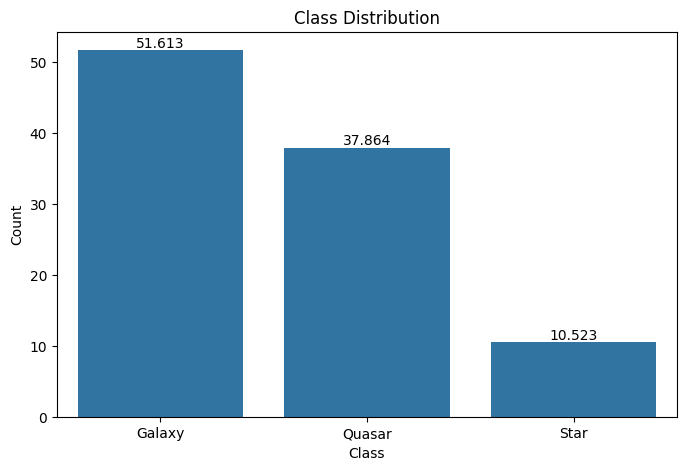

In [138]:
def plot_class_counts(normalize=True):
  """ Plot the class count distribution """
  plt.figure(figsize=(8, 5))
  stat= "percent" if normalize else "count"
  ax = sns.countplot(x=df['class'], stat=stat)

  labels = ["Galaxy", "Quasar", "Star"]
  ax.set_xticklabels(labels)

  # Add labels on top of bars
  for container in ax.containers:
    ax.bar_label(container)

  plt.title("Class Distribution")
  plt.xlabel("Class")
  plt.ylabel("Count")
  plt.show()

plot_class_counts(normalize=True)